In [32]:
import mailbox
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
#import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

In [33]:
def getmailtext(message): #getting plain text 'email body'
    body = None
    if message.is_multipart():
        for part in message.walk():
            if part.is_multipart():
                for subpart in part.walk():
                    if subpart.get_content_type() == 'text/plain':
                        body = subpart.get_payload(decode=True)
            elif part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True)
    elif message.get_content_type() == 'text/plain':
        body = message.get_payload(decode=True)
    mailtext=str(message['subject'])+" "+str(body)
    return mailtext


In [34]:
mbox = mailbox.mbox('Spam.mbox')

mlist_spam = []

for message in mbox:
    mlist_spam.append(getmailtext(message))
    #break

mbox_ham = mailbox.mbox('ham.mbox')

mlist_ham = []
count=0
for message in mbox_ham:
    
    mlist_ham.append(getmailtext(message))
    if count>301:
        break
    count+=1

In [35]:
import pandas as pd
spam_df = pd.DataFrame(mlist_spam, columns=["message"])
spam_df["label"] = "spam"

spam_df['length'] = spam_df['message'].map(lambda text: len(text))
print(spam_df.head())

ham_df = pd.DataFrame(mlist_ham, columns=["message"])
ham_df["label"] = "ham"

ham_df['length'] = ham_df['message'].map(lambda text: len(text))
print(ham_df.head())

                                             message label  length
0  Uninterrupted High Speed Connectivity b'View I...  spam     250
1  Opening For Experienced Java Engineer At GENPA...  spam      66
2  Opportunities in Mumbai for Php Developer, Php...  spam      59
3  =?UTF-8?B?IDEwJSBkaXNjb3VudCB3aGVuIHlvdSBidXkg...  spam    2281
4  Build to outlast b'View In New Tab\nTo Remove ...  spam     226
                                             message label  length
0  Get rewarded on all your spends with the Plati...   ham     238
1  New apartments were just posted near Seattle f...   ham      63
2  =?UTF-8?Q?Your_Career_in_Machine_Learning_Star...   ham   17774
3  Dear Customer, Better Body = Better Life b' \n...   ham     992
4  Top Deals Revealed : Great Indian Sale | Only ...   ham      70


In [36]:
mail_df = pd.concat([spam_df,ham_df])
from sklearn.utils import shuffle
mail_df = shuffle(mail_df)
len(mail_df)

683

In [37]:
mail_train, mail_test, y_train, y_test = train_test_split(mail_df['message'],mail_df['label'],test_size=0.33, random_state=42)

In [38]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [39]:
def features_transform(mail):
    bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(mail_train)
    #print(len(bow_transformer.vocabulary_))
    messages_bow = bow_transformer.transform(mail)
    print('sparse matrix shape:', messages_bow.shape)
    print('number of non-zeros:', messages_bow.nnz) 
    print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))
    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    #print(messages_tfidf.shape)
    return messages_tfidf

In [40]:
train_features=features_transform(mail_train)

sparse matrix shape: (457, 6153)
number of non-zeros: 19617
sparsity: 0.70%


# Naive Bayes Model

In [41]:
modelNB=MultinomialNB()

In [42]:
modelNB.fit(train_features,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
test_features=features_transform(mail_test)

sparse matrix shape: (226, 6153)
number of non-zeros: 9388
sparsity: 0.68%


In [56]:
predicted_class_NB=modelNB.predict(test_features)

In [57]:
from sklearn.metrics import confusion_matrix

In [54]:
def model_assessment(y_test,predicted_class):
    print('confusion matrix')
    print(confusion_matrix(y_test,predicted_class))
    print('accuracy')
    print(accuracy_score(y_test,predicted_class))
    plt.matshow(confusion_matrix(y_test, predicted_class), cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')

confusion matrix
[[ 58  39]
 [ 23 106]]
accuracy
0.725663716814


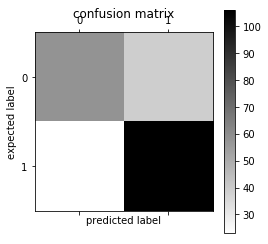

In [58]:
model_assessment(y_test,predicted_class_NB)

# Decision Tree Model

In [59]:
model_tree=DecisionTreeClassifier()

In [60]:
model_tree.fit(train_features,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [61]:
predicted_class_tree=model_tree.predict(test_features)

confusion matrix
[[58 39]
 [45 84]]
accuracy
0.628318584071


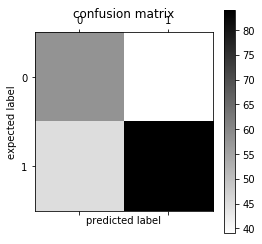

In [63]:
model_assessment(y_test,predicted_class_tree)

# Support Vector Machine

In [75]:
model_svm=SVC()

In [72]:
model_svm.fit(train_features,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [73]:
predicted_class_svm=model_tree.predict(test_features)

confusion matrix
[[58 39]
 [45 84]]
accuracy
0.628318584071


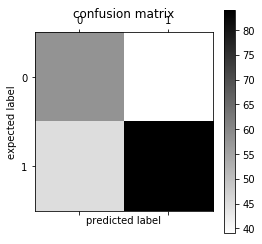

In [74]:
model_assessment(y_test,predicted_class_svm)